In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier #, MinCut2_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?
*  include logger

Epoch 0: Training loss 14.7752; Validation loss 17.0525, MAE: 17.2873; lr: 0.00100
	Add. Loss: Training 0.2504, Validation 0.2466
Epoch 5: Training loss 5.3170; Validation loss 14.3901, MAE: 14.6594; lr: 0.00100
	Add. Loss: Training 0.2250, Validation 0.2255
Epoch 10: Training loss 4.5342; Validation loss 14.8751, MAE: 15.1434; lr: 0.00100
	Add. Loss: Training 0.2412, Validation 0.2297
Epoch 15: Training loss 3.6621; Validation loss 14.1479, MAE: 14.4070; lr: 0.00100
	Add. Loss: Training 0.2443, Validation 0.2377
Epoch 20: Training loss 3.1622; Validation loss 13.9854, MAE: 14.2465; lr: 0.00100
	Add. Loss: Training 0.2462, Validation 0.2317
Epoch 25: Training loss 2.9279; Validation loss 14.4539, MAE: 14.7177; lr: 0.00100
	Add. Loss: Training 0.2453, Validation 0.2275
Epoch 30: Training loss 2.8043; Validation loss 13.8971, MAE: 14.1514; lr: 0.00100
	Add. Loss: Training 0.2470, Validation 0.2346
Epoch 35: Training loss 2.3952; Validation loss 14.0565, MAE: 14.3110; lr: 0.00100
	Add. Lo

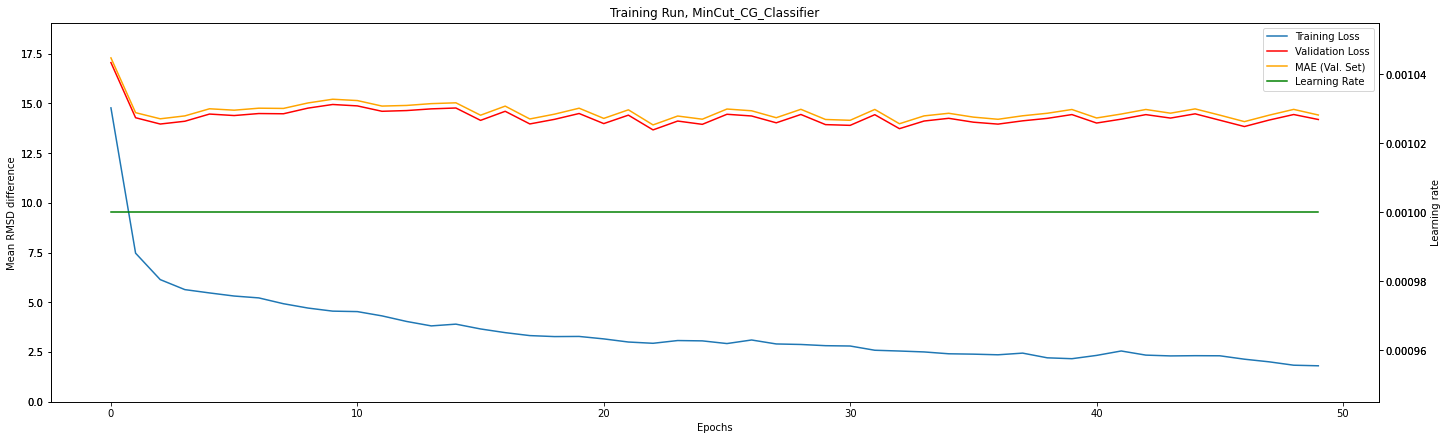

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=50,
    sched_T0=0,
    vectorize=vectorize,
    k=k,
    burn_in=0)

In [3]:
#get training run data

run_dir = "run_data/2022-05-12_16-18_MinCut_CG_Classifier"
burn_in = 0

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 1.8100 in epoch 49
Minimum Validation Loss (after 0 epochs) 13.6685 in epoch 22
Minimum MAE (after 0 epochs) 13.9190 in epoch 22


Validation Loss at 22 is 13.6685
5 before select
13.9679, 14.1989, 14.4927, 13.9854, 14.4103
5 after select
14.1133, 13.9480, 14.4539, 14.3681, 14.0251
MAE at 22 is 13.9190


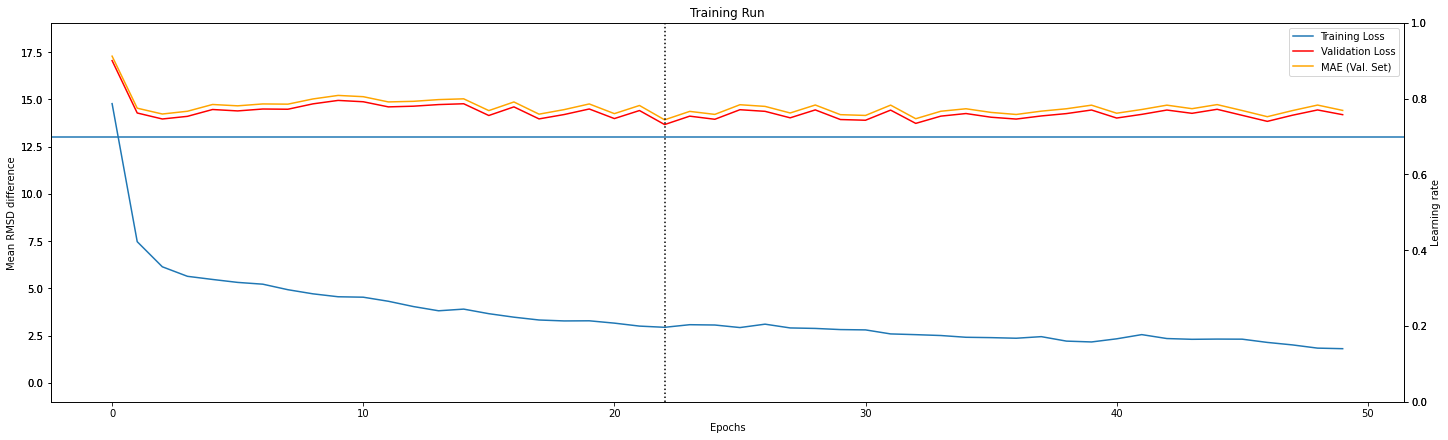

In [4]:
#plot the training run
select = 22
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
#ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Test Set
Minimum Loss: Label = 24.2220, Prediction = 24.2477, Loss = 0.0003
Maximum Loss: Label = 41.4410, Prediction = 11.9367, Loss = 29.0043
Mean Test loss: 	 12.4466
Std. Dev. of Test loss:  7.3551
Min loss: 		 0.0003
First Quantile: 	 6.1692
Median: 		 12.4935
Third Quantile: 	 19.4590
Max Loss: 		 29.0043
LinregressResult(slope=-0.2799325139242085, intercept=21.064500590818827, rvalue=-0.1379564665863917, pvalue=0.02163803061391934, stderr=0.12119155507740702, intercept_stderr=1.9880244448595814)


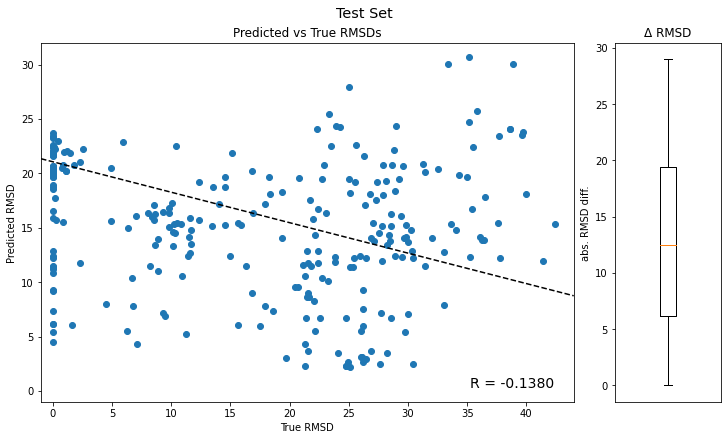

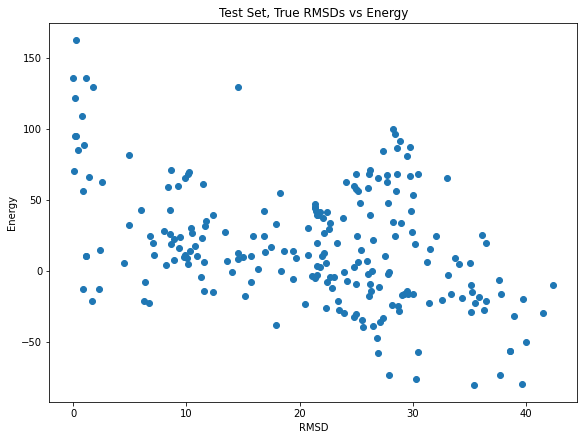

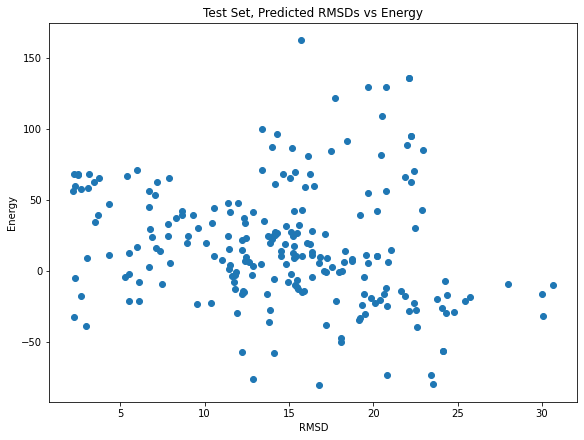

5S and tRNA Test Set
Minimum Loss: Label = 14.2530, Prediction = 14.2526, Loss = 0.0000
Maximum Loss: Label = 33.1290, Prediction = 9.9162, Loss = 22.7128
Mean Test loss: 	 4.5999
Std. Dev. of Test loss:  4.3801
Min loss: 		 0.0000
First Quantile: 	 1.4418
Median: 		 2.9657
Third Quantile: 	 6.7987
Max Loss: 		 22.7128
LinregressResult(slope=0.7805191656996284, intercept=3.9867023461315902, rvalue=0.6894200177345368, pvalue=1.4386297272573653e-153, stderr=0.024942638000238996, intercept_stderr=0.4283036694352497)


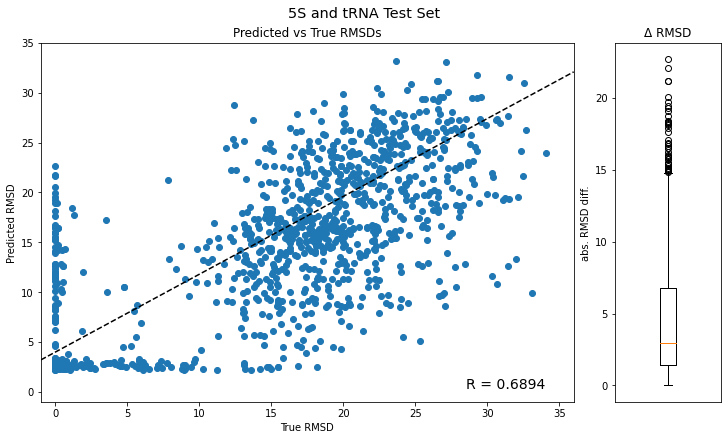

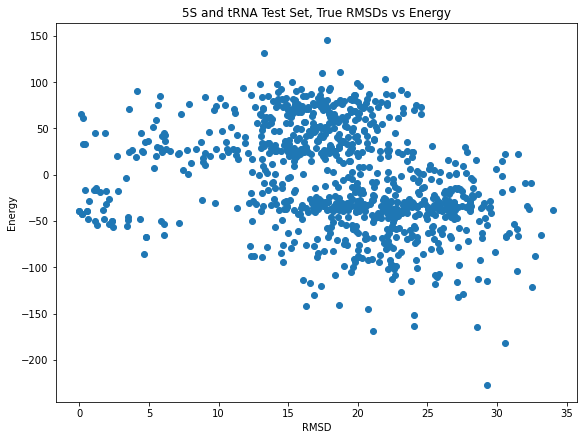

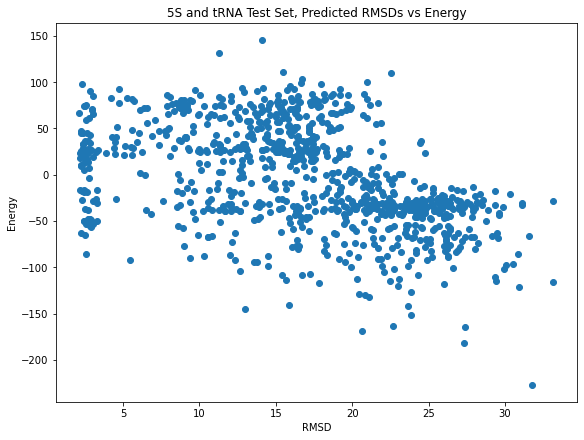

Training Set
Minimum Loss: Label = 13.1620, Prediction = 13.1634, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 17.7094, Loss = 17.2094
Mean Test loss: 	 3.2768
Std. Dev. of Test loss:  3.0621
Min loss: 		 0.0000
First Quantile: 	 0.8505
Median: 		 2.4443
Third Quantile: 	 4.8670
Max Loss: 		 17.2094
LinregressResult(slope=0.927435785014729, intercept=2.76769759575258, rvalue=0.8684712505524436, pvalue=3.351319185381467e-233, stderr=0.019228586282056818, intercept_stderr=0.35459191219240316)


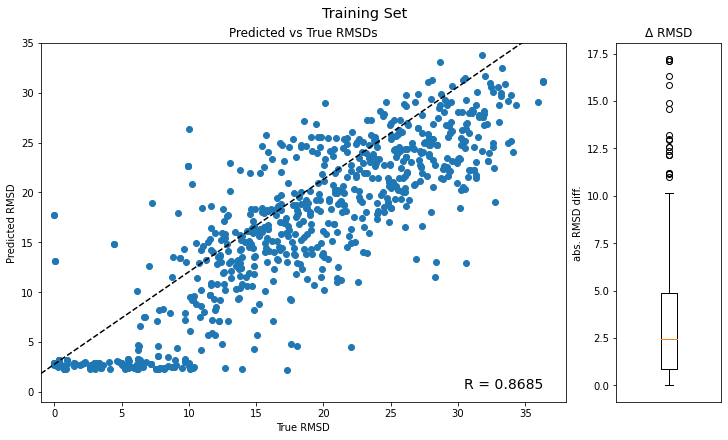

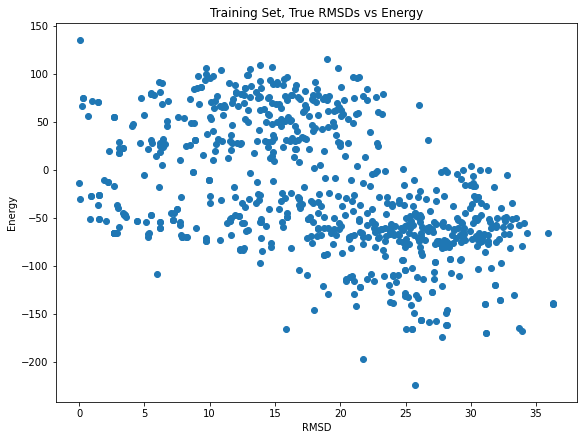

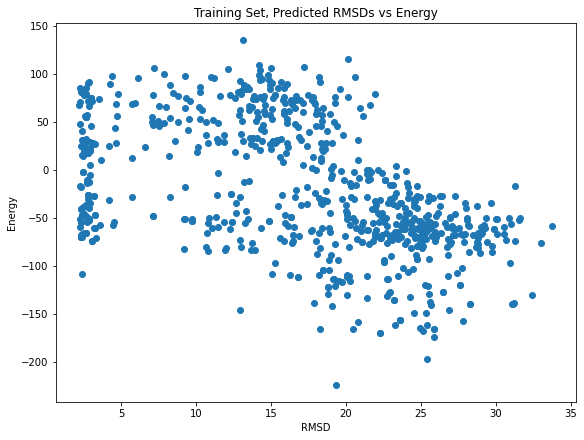

Validation Set
Minimum Loss: Label = 15.3190, Prediction = 15.3701, Loss = 0.0013
Maximum Loss: Label = 61.9850, Prediction = 13.3211, Loss = 48.1639
Mean Test loss: 	 13.3961
Std. Dev. of Test loss:  10.3202
Min loss: 		 0.0013
First Quantile: 	 5.7770
Median: 		 11.2153
Third Quantile: 	 18.8979
Max Loss: 		 48.1639
LinregressResult(slope=0.4688742509050077, intercept=15.282702515507005, rvalue=0.20401513438463295, pvalue=4.31162048029883e-05, stderr=0.11334810527421073, intercept_stderr=2.081163445869643)


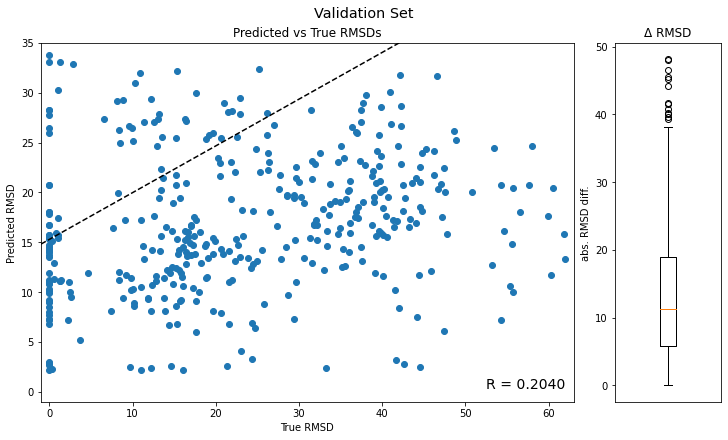

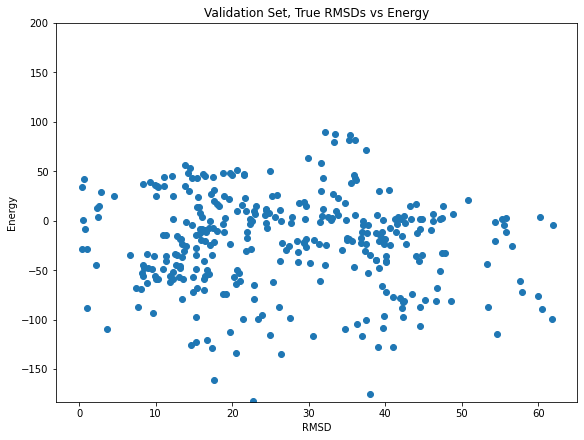

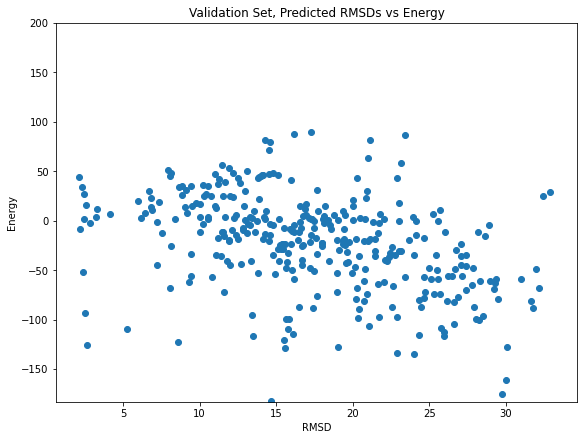

LinregressResult(slope=0.4602895104643825, intercept=13.207788067106558, rvalue=0.3232419355154884, pvalue=1.3229770768253766e-37, stderr=0.03492145885390229, intercept_stderr=0.6283889959490969)


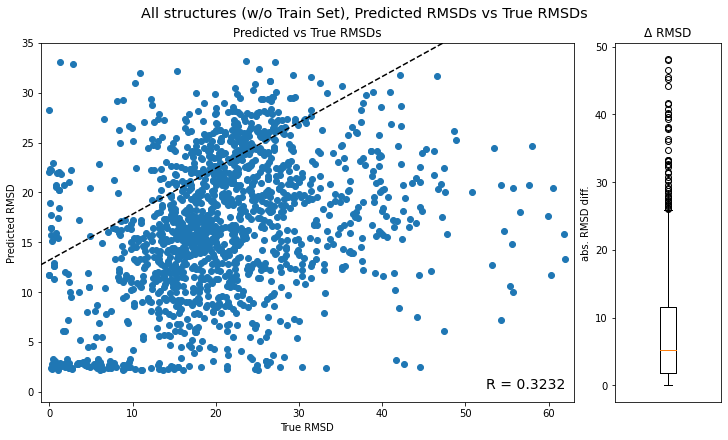

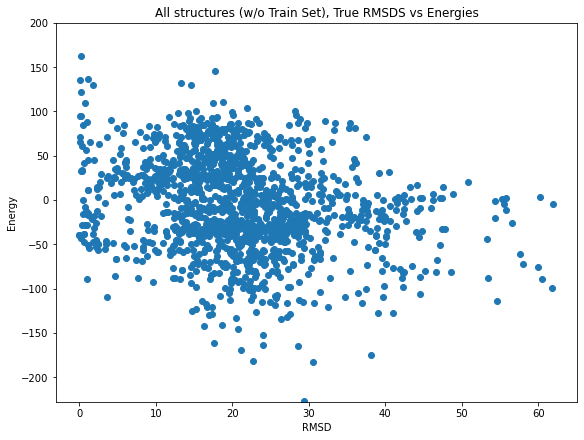

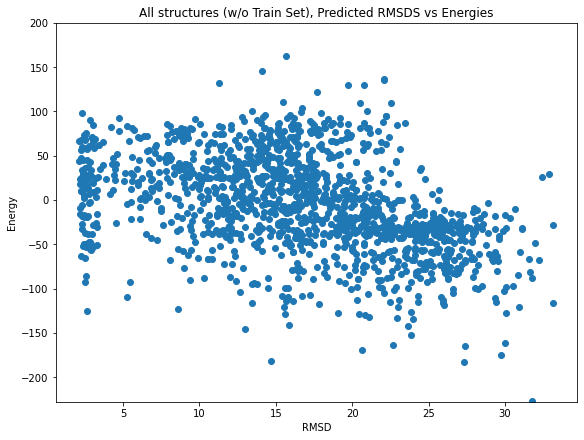

In [5]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    print("Model not in global variables")
    model = MinCut_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load(f"{run_dir}/model_data/epoch_{select}.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9594764120095552, intercept=0.9498062348515859, rvalue=0.9642193937610933, pvalue=1.3733046511202001e-160, stderr=0.015907829874483755, intercept_stderr=0.3358964033833028)


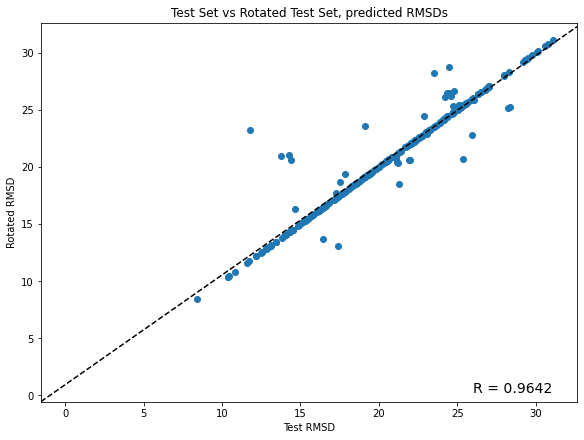

LinregressResult(slope=1.000085906271059, intercept=0.1148573568169855, rvalue=0.986611374478998, pvalue=1.2717899542193025e-218, stderr=0.009968947254733247, intercept_stderr=0.14355436575037928)


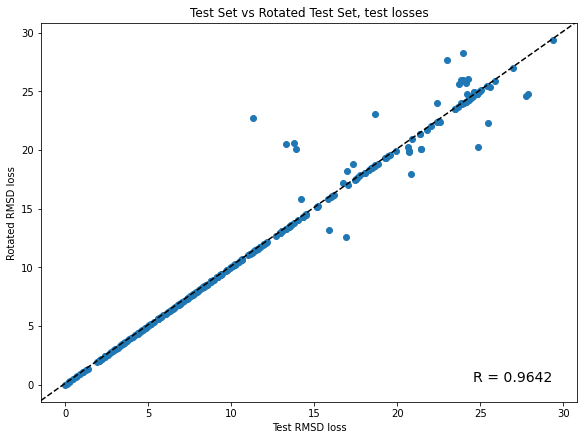

LinregressResult(slope=0.9459046093311229, intercept=1.1144539104374402, rvalue=0.9536610015085699, pvalue=0.0, stderr=0.009076917682429513, intercept_stderr=0.17670116790818752)


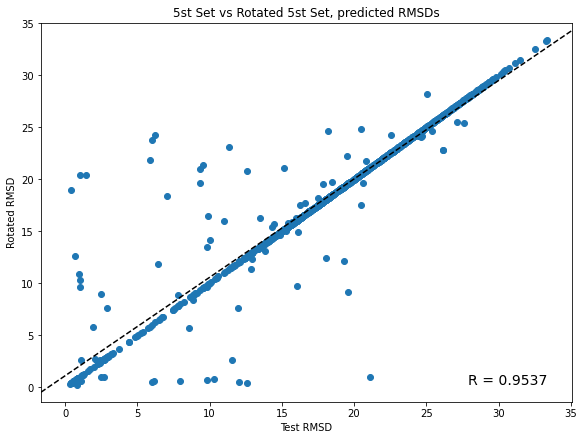

LinregressResult(slope=0.9656676642485449, intercept=0.2793978411235063, rvalue=0.9168766431510817, pvalue=0.0, stderr=0.01278682001523445, intercept_stderr=0.08416169374075845)


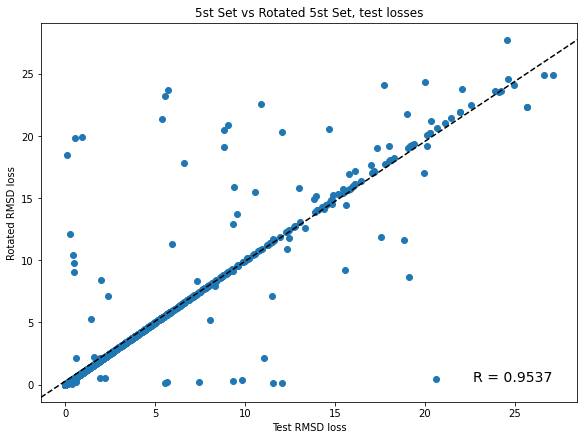

In [6]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")